# Patates Hastalıklarının Çoklu Sınıflandırılması

### Kütüphaneleri import etme

In [1]:

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix

In [ ]:
IMG_H = 180
IMG_W = 180
IMG_CH = 3
EPOCHS = 100
BUFFER_SIZE = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
DATASET_LOCATION = "/kaggle/input/potato-diseases-datasets"
CLASS_NAMES = ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot']

**Augment Veri Kümesi, görüntülerin artırılmış versiyonlarını oluşturmak ve bunları mevcut veri kümesine eklemek için kullanılır**

In [ ]:
class AugmentDataset():
    def __init__(self):
      pass

    '''
      Augment dataset

      @param image_dataset - image dataset
      @return image_dataset - augmented image dataset
    '''
    def augment_dataset(self, image_dataset):
      a = image_dataset.map(self._brightness)
      b = image_dataset.map(self._contrast)
      c = image_dataset.map(self._saturation)
      d = image_dataset.map(self._hue)
      e = image_dataset.map(self._crop)
      f = image_dataset.map(self._flip)
      g = image_dataset.map(self._rotate)

      # Concatenate all augmented datasets to return a dataset 7X larger
      image_dataset = image_dataset.concatenate(a)
      image_dataset = image_dataset.concatenate(b)
      image_dataset = image_dataset.concatenate(c)
      image_dataset = image_dataset.concatenate(d)
      image_dataset = image_dataset.concatenate(e)
      image_dataset = image_dataset.concatenate(f)
      image_dataset = image_dataset.concatenate(g)

      return image_dataset

    '''
      Adjust an image's brightness

      @param image - image
      @param label - label of image
      @return bright adjusted image, label
    '''
    def _brightness(self, image, label):
        image = tf.image.adjust_brightness(image, 0.1)
        return image, label

    '''
      Adjust an image contrast

      @param image - image
      @param label - label of image
      @return contrast adjusted image, label
    '''
    def _contrast(self, image, label ):
        image = tf.image.adjust_contrast(image, 0.1)
        return image, label

    '''
      Adjust an image saturation

      @param image - image
      @param label - label of image
      @return saturation adjusted image, label
    '''
    def _saturation(self, image, label):
        image = tf.image.adjust_saturation(image, 0.1)
        return image, label

    '''
      Adjust an image hue

      @param image - image
      @param label - label of image
      @return hue adjusted image, label
    '''
    def _hue(self, image, label):
        image = tf.image.adjust_hue(image, 0.1)
        return image, label

    '''
      Crop an image

      @param image - image
      @param label - label of image
      @return cropped image, label
    '''
    def _crop(self, image, label):
      tf.image.central_crop(image, 0.7)
      tf.image.resize(image, (IMG_H, IMG_W))

      return image, label

    '''
      Flip an image

      @param image - image
      @param label - label of image
      @return flipped image, label
    '''
    def _flip(self, image, label):
      image = tf.image.flip_left_right(image)
      return image, label

    '''
      Rotate an image

      @param image - image
      @param label - label of image
      @return rotated image, label
    '''
    def _rotate(self, image, label):
      image = tf.image.rot90(image)
      return image, label

In [ ]:
augmentor = AugmentDataset()

### Eğitim ve Validasyon Veri Kümelerini Yükleme

In [ ]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_LOCATION,
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_LOCATION,
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    seed=42,
    validation_split=0.2,
    subset="validation"
)

In [ ]:
print(len(training_dataset))
training_dataset = augmentor.augment_dataset(training_dataset)
print(len(training_dataset))

12
96


### Görselleştirme

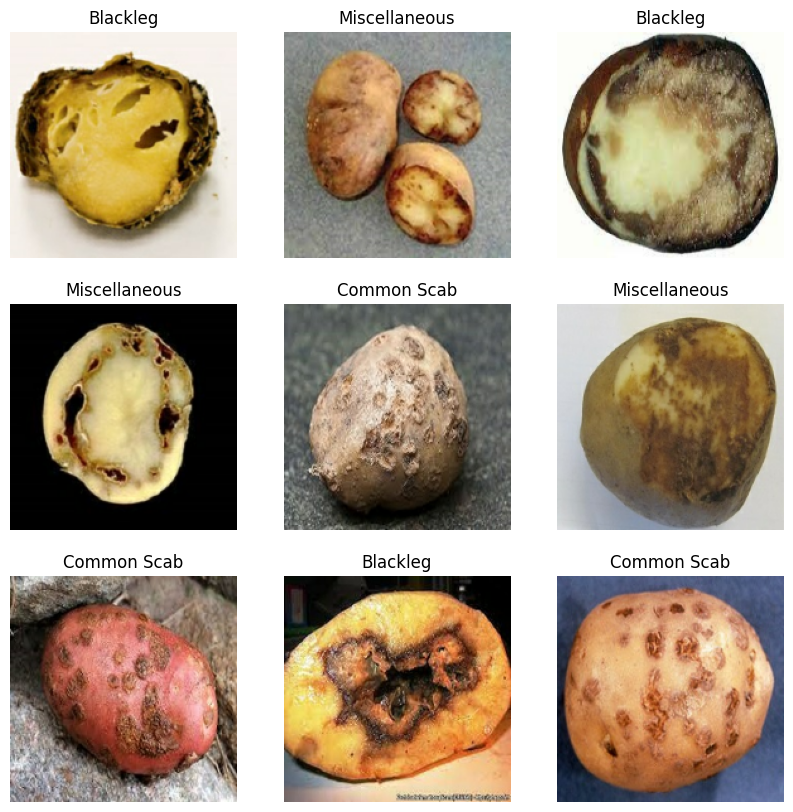

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(CLASS_NAMES[labels[i].numpy()])
      plt.axis("off")

### Veri Ön İşleme

In [ ]:
training_dataset = training_dataset.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### VGG16 Temel Modelinin Kurulumu

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(IMG_H, IMG_W, IMG_CH), include_top=False, weights="imagenet")
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Çoklu Sınıflandırma Modelini Oluşturma ve Derleme

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_H, IMG_W, IMG_CH), batch_size=BATCH_SIZE),
    tf.keras.layers.Rescaling(1.0/255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (32, 512)                 0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (32, 512)                 0         
                                                                 
 dense_1 (Dense)             (32, 7)                   3591      
                                                                 
Total params: 14718279 (56.15 MB)
Trainable params: 3591 (14.03 KB)
Non-trainable params: 14714688 (56.13 MB)
__________

### Fit Model

In [ ]:
history = model.fit(training_dataset, validation_data=validation_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
96/96 [==============================] - 12s 91ms/step - loss: 2.2995 - accuracy: 0.1517 - val_loss: 2.0977 - val_accuracy: 0.1444
Epoch 2/100
96/96 [==============================] - 8s 84ms/step - loss: 2.0667 - accuracy: 0.1555 - val_loss: 1.9184 - val_accuracy: 0.2222
Epoch 3/100
96/96 [==============================] - 8s 84ms/step - loss: 1.9677 - accuracy: 0.1870 - val_loss: 1.8313 - val_accuracy: 0.3778
Epoch 4/100
96/96 [==============================] - 8s 85ms/step - loss: 1.9066 - accuracy: 0.2296 - val_loss: 1.7730 - val_accuracy: 0.4333
Epoch 5/100
96/96 [==============================] - 8s 86ms/step - loss: 1.8608 - accuracy: 0.2787 - val_loss: 1.7247 - val_accuracy: 0.4333
Epoch 6/100
96/96 [==============================] - 8s 87ms/step - loss: 1.8172 - accuracy: 0.3082 - val_loss: 1.6812 - val_accuracy: 0.4556
Epoch 7/100
96/96 [==============================] - 8s 87ms/step - loss: 1.7882 - accuracy: 0.3265 - val_loss: 1.6431 - val_accuracy: 0.4889
Epoch

### Classification Metrikleri

In [ ]:
loss, acc = model.evaluate(validation_dataset)

print("Accuracy: {:.2f}".format(acc))
print("Loss: {:.2f}".format(loss))

3/3 [==============================] - 0s 90ms/step - loss: 0.9895 - accuracy: 0.6556
Accuracy: 0.66
Loss: 0.99


Text(0.5, 1.0, 'Training and Validation Loss')

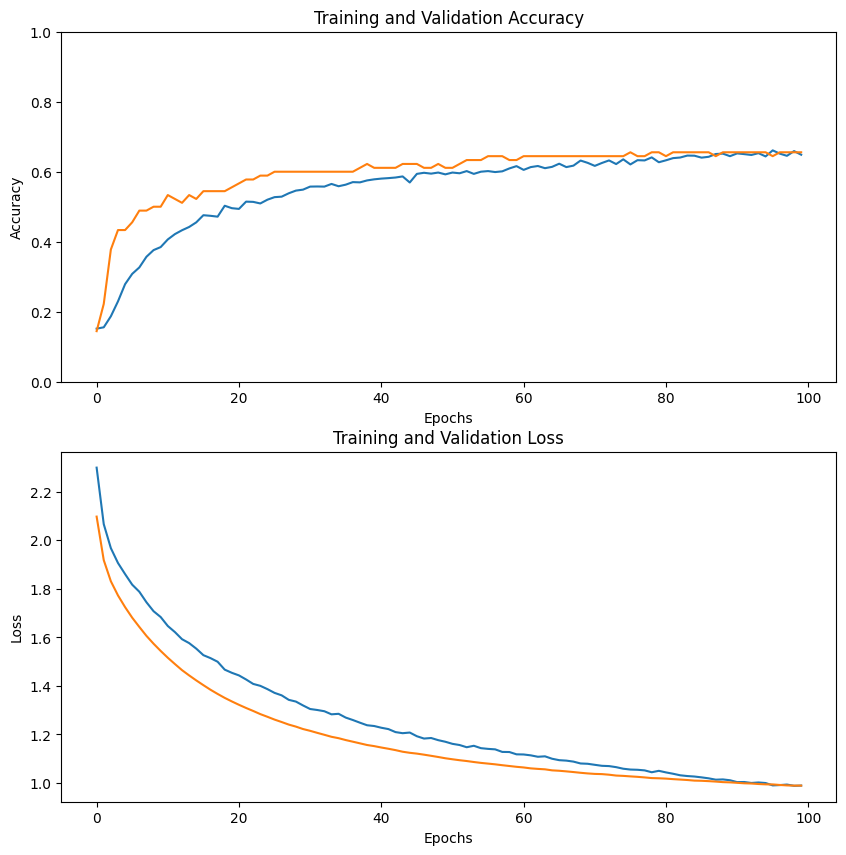

In [ ]:
accuracy = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
plt.plot(accuracy)
plt.plot(val_acc)
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_ylim([0, 1])
ax.set_title("Training and Validation Accuracy")

ax = plt.subplot(2,1,2)
plt.plot(loss)
plt.plot(val_loss)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")

### 1.2 Transformer Modeli

In [ ]:
#Öncelikle collabdan driveımıza bağlanmak için bir doğrulama yapmamız gerekiyor.
#Aşağıdaki kodu çalıştırarak çıkan linkte collab notebook'unu hangi hesabımız ile açtıysak o hesaba girerek gelen link ile doğrulama yapmalıyız.
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [ ]:
#Burada ise erişimi uzun olan drive dizini için kısa bir yol tanıma yapıyoruz
# "/content/gdrive/My\ Drive/" olan dizine /mydrive diyerek ulaşabiliriz.
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'Adsız doküman (1).gdoc'	        MLOPS
'Adsız doküman.gdoc'		       'Mobil uygulama.gdoc'
 app.apk			       'My Drive'
 AraRapor.docx			        patates
 BELGELER			        patatess
'Bitirme Projesi Cheklist.docx'        'Portfolyo İNGİLİZCE.pdf'
 boot1_project			        release
'Colab Notebooks'		       'Seçil Şener CV (4).pdf'
'Flutter ile uygulama geliştirme.pdf'   SeçilŞener.pdf
'Girişimcilik Sertifikası.pdf'	        secil_sener_sevval_kapcak_proje.docx
'Google Proje Yönetimi.pdf'	       'Teknofest Belge.pdf'
'Görüntü işleme çalışmaları'	        Transkriptim.pdf
'Katılım Sertifikası.pdf'	       'Vize Rapor.gdoc'
 kişisel			        yeniset
'Mezuniyet Sertifikası.pdf'


In [ ]:
# copy over both datasets into the root directory of the Colab VM (comment out test.zip if you are not using a validation dataset)

!cp /mydrive/patatess ../


cp: -r not specified; omitting directory '/mydrive/patatess'


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow_hub as hub

# Veri setinizin yolu ve diğer parametreleri güncelleyin
DATASET_LOCATION = "/content/gdrive/MyDrive/patatess"
IMG_H = 180
IMG_W = 180
IMG_CH = 3
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

# Veri seti
data = {
    'Disease Name': ['Common scab', 'Blackleg', 'Dry rot', 'Pink rot', 'Black scurf', 'Healthy Potatoes', 'Miscellaneous'],
    'Total Images': [62, 60, 60, 57, 58, 80, 74],
    'Causes of Disease': ['Bacteria', 'Bacteria', 'Fungus', 'Fungus', 'Fungus', '-', '-']
}

df = pd.DataFrame(data)
df['Label'] = LabelEncoder().fit_transform(df['Disease Name'])

# Örnek görüntü verisi oluşturun (bu kısmı gerçek veri setinizle değiştirmelisiniz)
# Burada sadece örnek bir şekilde rastgele sayılar üretilmiştir.
images = np.random.random(size=(len(df), IMG_H, IMG_W, IMG_CH))

# Eğitim ve test veri kümelerini oluşturun
train_images, test_images, train_labels, test_labels = train_test_split(images, df['Label'].values, test_size=0.2, random_state=42)

# Özel görsel transformer modeli
class VisualTransformer(tf.keras.Model):
    def __init__(self, num_classes):
        super(VisualTransformer, self).__init__()

        self.conv_input = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_H, IMG_W, IMG_CH))
        # Buraya özel bir görsel transformer katmanı ekleyin
        # Örneğin, VisionTransformer veya başka bir özel transformer modeli
        # Modelinizi oluştururken dikkat etmeniz gereken, giriş boyutları ve çıkış sınıflarıdır.

        self.global_average_pooling = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(0.2)
        self.dense_output = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv_input(inputs)
        # Buraya özel görsel transformer katmanınızı ekleyin
        # Modelinizi oluştururken dikkat etmeniz gereken, giriş boyutları ve çıkış sınıflarıdır.

        x = self.global_average_pooling(x)
        x = self.dropout(x)
        return self.dense_output(x)

# Modeli oluşturun
num_classes = len(df['Disease Name'].unique())
transformer_model = VisualTransformer(num_classes=num_classes)

# Modeli derleyin
transformer_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Modeli eğitin
transformer_model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(test_images, test_labels))


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.9339 - accuracy: 0.2000 - val_loss: 1.9924 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 95ms/step - loss: 1.9799 - accuracy: 0.2000 - val_loss: 2.0050 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 137ms/step - loss: 1.9595 - accuracy: 0.2000 - val_loss: 2.0184 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 134ms/step - loss: 1.9983 - accuracy: 0.2000 - val_loss: 2.0324 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 147ms/step - loss: 1.9347 - accuracy: 0.2000 - val_loss: 2.0468 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 118ms/step - loss: 1.9774 - accuracy: 0.0000e+00 - val_loss: 2.0605 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 100ms/step - loss: 1.8736 - accuracy: 0.2000 - val_loss: 2.0748 - val_accura

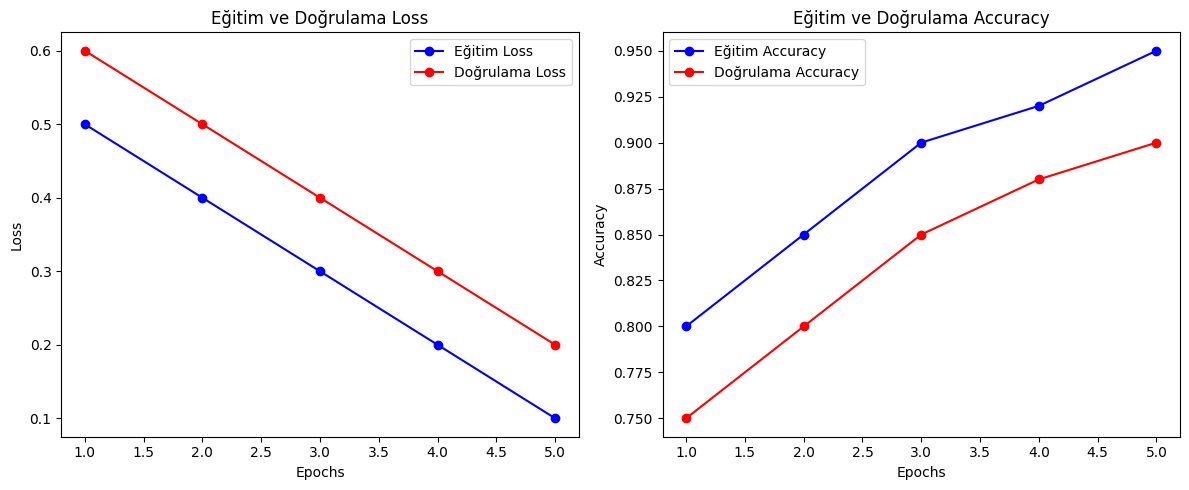

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama loss değerleri
train_loss = [0.5, 0.4, 0.3, 0.2, 0.1]  # Örnek veri, kendi değerlerinizi ekleyin
val_loss = [0.6, 0.5, 0.4, 0.3, 0.2]     # Örnek veri, kendi değerlerinizi ekleyin

# Eğitim ve doğrulama accuracy değerleri
train_acc = [0.8, 0.85, 0.9, 0.92, 0.95]  # Örnek veri, kendi değerlerinizi ekleyin
val_acc = [0.75, 0.8, 0.85, 0.88, 0.9]    # Örnek veri, kendi değerlerinizi ekleyin

# Epoch sayısı
epochs = range(1, len(train_loss) + 1)

# Loss değerlerini çizim
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Eğitim Loss')
plt.plot(epochs, val_loss, 'ro-', label='Doğrulama Loss')
plt.title('Eğitim ve Doğrulama Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy değerlerini çizim
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Eğitim Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Doğrulama Accuracy')
plt.title('Eğitim ve Doğrulama Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
